In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from pprint import pprint

In [26]:
df = pd.read_csv('./dataset/Iris.csv')
df = df.drop('Id', axis=1)
df = df.rename(columns={
    'Species': 'label',
    'SepalLengthCm': 'sepal_length',
    'SepalWidthCm': 'sepal_width',
    'PetalLengthCm': 'petal_length',
    'PetalWidthCm': 'petal_width',
})
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   label         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
def train_test_split(df, test_size):
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df

In [28]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.1)

In [29]:
test_df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
98,5.1,2.5,3.0,1.1,Iris-versicolor
107,7.3,2.9,6.3,1.8,Iris-virginica
10,5.4,3.7,1.5,0.2,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
130,7.4,2.8,6.1,1.9,Iris-virginica


In [30]:
data = train_df.values

In [31]:
def check_purity(data):
    label_colums = data[:, -1]

    unique_classes = np.unique(label_colums)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [32]:
def classify_data(data):
    label_colums = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(
        label_colums,
        return_counts=True
    )

    index = counts_unique_classes.argmax()
    classidication = unique_classes[index]

    return classidication

In [34]:
classify_data(train_df[train_df.petal_width > 1.2].values)

'Iris-virginica'

In [35]:
def get_potential_splits(data):
    potential_splits = {}
    _, n_columns = data.shape
    for i_column in range(n_columns - 1):
        potential_splits[i_column] = []
        values = data[:, i_column]
        unique_values = np.unique(values)

        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2

                potential_splits[i_column].append(potential_split)

    return potential_splits

In [37]:
potential_splits = get_potential_splits(train_df.values)

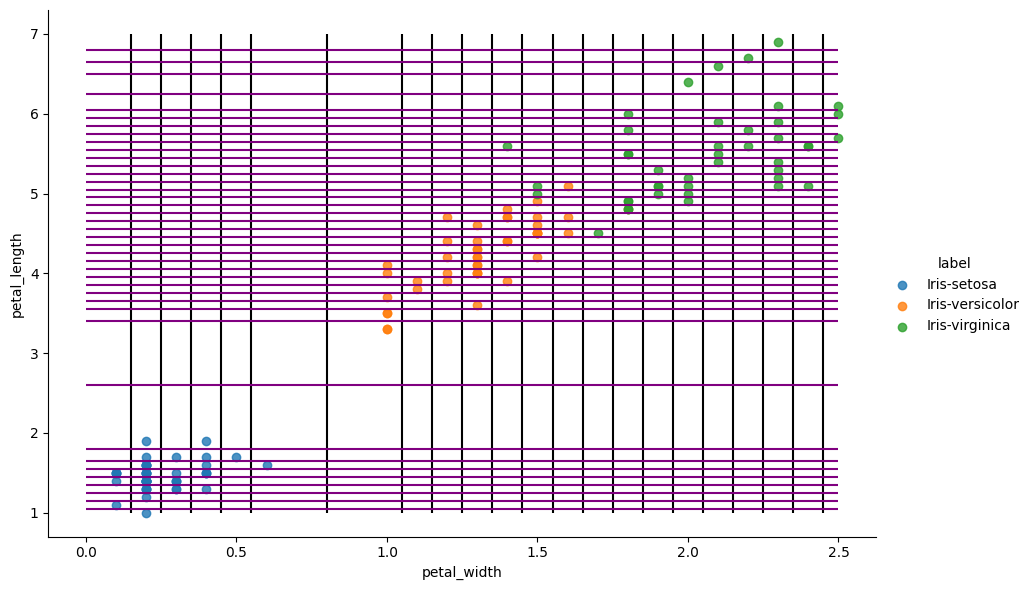

In [56]:
sns.lmplot(
    data=train_df,
    x='petal_width',
    y='petal_length',
    hue='label',
    fit_reg=False,
    height=6,
    aspect=1.5
)

plt.vlines(x=potential_splits[3], ymin=1, ymax=7, color='black')
plt.hlines(y=potential_splits[2], xmin=0, xmax=2.5, color='purple')

In [82]:
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]
    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values > split_value]

    return data_below, data_above

In [91]:
split_column = 3
split_value = 0.8

In [92]:
data_below, data_above = split_data(data, split_column, split_value)

(0.0, 2.6)

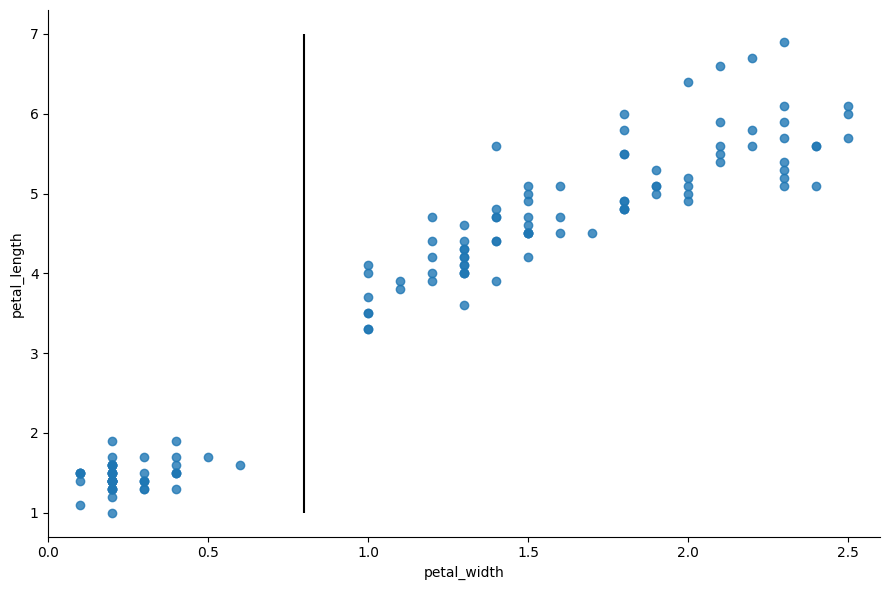

In [93]:
plotting_df = pd.DataFrame(data, columns=df.columns)

sns.lmplot(
    data=plotting_df,
    x='petal_width',
    y='petal_length',
    fit_reg=False,
    height=6,
    aspect=1.5,
)
plt.vlines(x=split_value, ymin=1, ymax=7, color='black')
plt.xlim(0, 2.6)

$S_{i} = - \sum_{k=1}^{n} P_{i,k}\log_{2}P_{i,k}$ \
$S_{overall} =  \sum_{i=1}^{2} P_{i}  \cdot S_{i} $

In [94]:
def calculate_entropy(data):
    label_colums = data[:, -1]
    _, counts = np.unique(label_colums, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

In [96]:
def calculate_overall_entropy(data_below, data_above):
    n_data_points = len(data_below) + len(data_above)

    p_data_below = len(data_below) / n_data_points
    p_data_above = len(data_above) / n_data_points

    overall_entropy = (
        p_data_below * calculate_entropy(data_below) +
        p_data_above * calculate_entropy(data_above)
    )

    return overall_entropy

In [103]:
def determine_best_split(data, potential_splits):
    overall_entropy = 999

    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(
                data,
                split_column=column_index,
                split_value=value,
            )
            current_overall_entropy = calculate_overall_entropy(
                data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column, best_split_value = column_index, value

    return best_split_column, best_split_value

In [104]:
potential_splits = get_potential_splits(data)

In [105]:
determine_best_split(data, potential_splits)

(3, 0.8)

## Algorithm

In [122]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):

    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df

    # base case
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        return classification

    # recursive part
    else:
        counter += 1

        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(
            data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        feater_names = COLUMN_HEADERS[split_column]
        question = f'{feater_names}  <= {split_value}'
        sub_tree = {question: []}

        yes_answer = decision_tree_algorithm(
            data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(
            data_above, counter, min_samples, max_depth)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

        return sub_tree

In [123]:
tree = decision_tree_algorithm(train_df, min_samples=2, max_depth=3)
tree

{'petal_width  <= 0.8': ['Iris-setosa',
  {'petal_width  <= 1.65': [{'petal_length  <= 4.95': ['Iris-versicolor',
      'Iris-virginica']},
    'Iris-virginica']}]}

## Classification

In [133]:
example = test_df.iloc[1]
example

sepal_length               7.3
sepal_width                2.9
petal_length               6.3
petal_width                1.8
label           Iris-virginica
Name: 107, dtype: object

In [134]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    featuer_name, comparison_operator, value = question.split()

    if example[featuer_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    if not isinstance(answer, dict):
        return answer

    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [135]:
classify_example(example, tree)

'Iris-virginica'

## Accuracy

In [138]:
def calculate_accuracy(df, tree):
    df['classification'] = df.apply(
        classify_example,
        axis=1,
        args=(tree,)
    )
    df['classidication_correct'] = df.classification == df.label
    accuracy = df.classidication_correct.mean()
    return accuracy

In [139]:
calculate_accuracy(test_df, tree)

0.9333333333333333

In [141]:
test_df.loc[77]

sepal_length                          6.7
sepal_width                           3.0
petal_length                          5.0
petal_width                           1.7
label                     Iris-versicolor
classsidication            Iris-virginica
classification             Iris-virginica
classidication_correct              False
Name: 77, dtype: object

In [142]:
pprint(tree)

{'petal_width  <= 0.8': ['Iris-setosa',
                         {'petal_width  <= 1.65': [{'petal_length  <= 4.95': ['Iris-versicolor',
                                                                              'Iris-virginica']},
                                                   'Iris-virginica']}]}
